#### Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

#### Загрузим и рассмотрим данные

In [2]:
train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [3]:
train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

Как видно, у нас есть недостающие значения для возраста и номера каюты пассажиров, а также для регистрации нескольких пассажиров в треировочном наборе.

Но прежде чем разбираться с ними, рассмотрим подробнее, какие данные содержаться в колонках типа object. Взглянем на примеры значений из этих колонок и количество уникальных значений в каждой.

In [4]:
object_cols = [col for col in train.columns if train[col].dtype == 'object']
train[object_cols].head()

,Name,Sex,Ticket,Cabin,Embarked
0,"Braund, Mr. Owen Harris",male,A/5 21171,NaN,S
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,PC 17599,C85,C
2,"Heikkinen, Miss. Laina",female,STON/O2. 3101282,NaN,S
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,113803,C123,S
4,"Allen, Mr. William Henry",male,373450,NaN,S


In [5]:
for col in object_cols:
    print(f'{col} содержит {len(train[col].unique())} уникальных значений')

Name содержит 891 уникальных значений
Sex содержит 2 уникальных значений
Ticket содержит 681 уникальных значений
Cabin содержит 148 уникальных значений
Embarked содержит 4 уникальных значений


Колонки Sex и Embarked содержат небольшое число уникальных значений, что позволяет использовать их в качестве категориальных переменных.
Колонки Name и Cabin содержат большее количество разных значений, однако можно заметить, что в их значениях содержатся повторяющиеся элементы:

In [6]:
train[train['Cabin'].notna()] [['Name', 'Cabin']][1:10]

,Name,Cabin
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",C123
6,"McCarthy, Mr. Timothy J",E46
10,"Sandstrom, Miss. Marguerite Rut",G6
11,"Bonnell, Miss. Elizabeth",C103
21,"Beesley, Mr. Lawrence",D56
23,"Sloper, Mr. William Thompson",A6
27,"Fortune, Mr. Charles Alexander",C23 C25 C27
31,"Spencer, Mrs. William Augustus (Marie Eugenie)",B78
52,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",D33


Из имен пассажиров можно извлечь префиксы типа "Mr.", "Miss." и использовать в качестве категориальных переменных. Посмотрим, какое количество уникальных значений мы можем получить в этом случае:

In [7]:
print(train['Name'].apply(lambda x: x.split()[1]).unique())

# Такой метод не позволяет нам точно отфильтровать все префиксы, однако дает понять что префикс обычно 
# записан с точкой после него, а также что имена некоторых пассажиров были записаны в ином стиле. Это
# поможет нам произвести более точный поиск.

train['Prefix'] = train['Name'].apply(lambda x: [part for part in x.split() if part.endswith('.')][0])

print(train['Prefix'].value_counts())

['Mr.' 'Mrs.' 'Miss.' 'Master.' 'Planke,' 'Don.' 'Rev.' 'Billiard,' 'der'
 'Walle,' 'Dr.' 'Pelsmaeker,' 'Mulder,' 'y' 'Steen,' 'Carlo,' 'Mme.'
 'Impe,' 'Ms.' 'Major.' 'Gordon,' 'Messemaeker,' 'Mlle.' 'Col.' 'Capt.'
 'Velde,' 'the' 'Shawah,' 'Jonkheer.' 'Melkebeke,' 'Cruyssen,']
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Mlle.          2
Col.           2
Major.         2
Mme.           1
Lady.          1
Countess.      1
Sir.           1
Capt.          1
Don.           1
Jonkheer.      1
Ms.            1
Name: Prefix, dtype: int64


По неизвестной причине для некоторых имен указано еще одно имя в скобках:

In [8]:
train[train['Name'].apply(lambda x: set(x)) >= {'(', ')'}]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S,Mrs.
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C,Mrs.
15,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.0,0,0,248706,16.0000,NaN,S,Mrs.
...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S,Mrs.
874,875,1,2,"Abelson, Mrs. Samuel (Hannah Wizosky)",female,28.0,1,0,P/PP 3381,24.0000,NaN,C,Mrs.
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C,Mrs.
880,881,1,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,NaN,S,Mrs.


In [9]:
print(train[train['Name'].apply(lambda x: set(x)) >= {'(', ')'}]['Sex'].value_counts(),
     '\n\n',
     train[train['Name'].apply(lambda x: set(x)) >= {'(', ')'}]['Prefix'].value_counts())

female    129
male       14
Name: Sex, dtype: int64 

 Mrs.         121
Mr.           12
Miss.          4
Sir.           1
Master.        1
Mlle.          1
Lady.          1
Dr.            1
Countess.      1
Name: Prefix, dtype: int64


Большинство пассажиров с указанным в скобках именем - замужние женщины. Возможно, второе имя это имя до заключения брака. У большинства пассажиров мужского пола, а так же пассажирок с префиксом "Miss." второе имя не указано.

Теперь обратим внимание на колонку "Cabin". По-видимому номера имеют имеют вид "Литера + Номер", где номер варьируется в диапазоне от единиц до более чем сотни, но количество литер ограничено. Можно предположить, что литера соответствует палубе, и так же использовать ее как категориальный параметр. Для получения литер из номеров кают удобнее будет использовать регулярные выражения.

In [10]:
a = np.nan
bool(a)

True

In [11]:
import re

# Как можно заметить, для некоторых пассажиров указано несколько номеров кают. Если эти номера содержат
# одинаковые литеры, вероятно они находятся на одной палубе. Поскольку нас в данном случае интересует только
# палуба, количество номеров не будет иметь значения.

def with_space(x):
    if x is not np.nan and re.search(r'\s', x):
        return re.search(r'\s', x).group()
    else:
        return np.nan

train[train['Cabin'].apply(with_space).notna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.00,3,2,19950,263.0000,C23 C25 C27,S,Mr.
75,76,0,3,"Moen, Mr. Sigurd Hansen",male,25.00,0,0,348123,7.6500,F G73,S,Mr.
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.00,3,2,19950,263.0000,C23 C25 C27,S,Miss.
97,98,1,1,"Greenfield, Mr. William Bertram",male,23.00,0,1,PC 17759,63.3583,D10 D12,C,Mr.
118,119,0,1,"Baxter, Mr. Quigg Edmond",male,24.00,0,1,PC 17558,247.5208,B58 B60,C,Mr.
128,129,1,3,"Peter, Miss. Anna",female,NaN,1,1,2668,22.3583,F E69,C,Miss.
297,298,0,1,"Allison, Miss. Helen Loraine",female,2.00,1,2,113781,151.5500,C22 C26,S,Miss.
299,300,1,1,"Baxter, Mrs. James (Helene DeLaudeniere Chaput)",female,50.00,0,1,PC 17558,247.5208,B58 B60,C,Mrs.
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S,Master.
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.00,2,2,PC 17608,262.3750,B57 B59 B63 B66,C,Miss.


Во всех случаях, когда для одного пассажира указано несколько номеров кают, они содержат одинаковую литеру и вероятно находятся на одной палубе. Однако для некоторых пассажиров помимо номера кают указана еще одна литера без цифр. В этих случаях будем ориентироваться на номер, содержащий и литеру, и цифры.
Если номер каюты отсутствует, укажем, что палуба неизвестна.

In [12]:
# При извлечении литер обнаружилось, что для нескольких пассажиров номер кают содержит только литеру без цифр. В
# этих случаях возьмем эти литеры без изменений.
def extract_letter(x):
    if isinstance(x, str):
        if re.search(r'[A-Z](?=\d+)', x):
            return re.search(r'[A-Z](?=\d+)', x).group(0)
        else:
            return x
    else:
        return 'Unknown'

train['Deck'] = train['Cabin'].apply(extract_letter)
train['Deck'].value_counts()

Unknown    687
C           59
B           47
E           33
D           33
A           15
F            9
G            7
T            1
Name: Deck, dtype: int64

Далее рассмотрим колонку "Ticket". Сразу можно заметить, что некоторые записи в ней представляют собой набор исключительно цифр, а неоторые состоят из цифр и букв. Сперва рассмотрим записи, состоящие только из цифр.

In [13]:
train[train['Ticket'].apply(lambda x: re.search(r'\A\d+\Z', x)).notna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix,Deck
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,Unknown
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr.,Unknown
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr.,E
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master.,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,Mrs.,Unknown
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev.,Unknown
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss.,B
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr.,C


In [14]:
# Похоже, что первая цифра в номере билета совпадает с номером класса, в котором путешествовал пассажир.

def compare(x):
    return str(x['Pclass']) == x['Ticket'][0]

train[train.apply(compare, axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix,Deck
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,Unknown
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q,Mr.,Unknown
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S,Mr.,E
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S,Master.,Unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q,Mrs.,Unknown
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S,Rev.,Unknown
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,Miss.,B
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,Mr.,C


В большинстве случаев первая цифра в номере билета действительно совпадает с номером класса. Проверим, будет ли ситуация аналогична для номеров, в которых содержатся не только цифры.

In [15]:
def numeric(x):
    if re.search(r'(?<=(\D|\S|\d)\s)\d+|(?<=\A)\d+\Z', x['Ticket']):
        return re.search(r'(?<=(\D|\S|\d)\s)\d+|(?<=\A)\d+\Z', x['Ticket']).group()[0] == str(x['Pclass'])
    else:
        return False

print('Общее количество записей, содержащих цифровой номер: ',
      train[train['Ticket'].apply(lambda x: re.search(r'(?<=\s)\d+\Z|(?<=\A)\d+\Z', x)).notna()]['Ticket'].count(),
     '\nКоличество записей, где первая цифра номера совпадает с номером класса:',
      train[train.apply(numeric, axis=1)]['Ticket'].count())

Общее количество записей, содержащих цифровой номер:  887 
Количество записей, где первая цифра номера совпадает с номером класса: 646


Примерно в двух третях записей первая цифра номера совпадает с номером класса. Возможно, это также можно учесть как категориальный параметр.

In [16]:
def ticket_match_class(x):
    if re.search(r'(?<=(\D|\S|\d)\s)\d+|(?<=\A)\d+\Z', x['Ticket']):
        return int(re.search(r'(?<=(\D|\S|\d)\s)\d+|(?<=\A)\d+\Z', x['Ticket']).group()[0] == str(x['Pclass']))
    else:
        return 0
train['TicketMatchClass'] = train.apply(ticket_match_class, axis=1)

Далее посмотрим, какие нецифровые сочетания содержатся в записях в колонке Ticket.

In [17]:
def alphanumeric(x):
    if re.search(r'\A\D+\S+(?=\s)|\A\D+\S+(?=\Z)', x):
        return re.search(r'\A\D+\S+(?=\s)|\A\D+\S+(?=\Z)', x).group(0)
    else:
        return np.nan

print(len(train['Ticket'].apply(alphanumeric).value_counts()))
train['Ticket'].apply(alphanumeric).value_counts()

48


PC             60
C.A.           27
STON/O 2.      12
A/5            10
W./C.           9
SOTON/O.Q.      8
CA.             8
SOTON/OQ        7
A/5.            7
CA              6
STON/O2.        6
F.C.C.          5
S.O.C.          5
SC/PARIS        5
LINE            4
SC/Paris        4
S.O./P.P.       3
A/4             3
A/4.            3
PP              3
SOTON/O2        2
SC/AH           2
S.C./PARIS      2
A.5.            2
A./5.           2
WE/P            2
P/PP            2
W/C             1
W.E.P.          1
S.P.            1
F.C.            1
A4.             1
S.O.P.          1
C 7075          1
C 7077          1
C 4001          1
C 17369         1
S.C./A.4.       1
Fa              1
SC              1
SCO/W           1
SC/AH Basle     1
SW/PP           1
SO/C            1
C.A./SOTON      1
S.W./PP         1
A/S             1
C 7076          1
Name: Ticket, dtype: int64

Некоторые сочетания символов очень похожи друг на друга, но в целом в данном случае проще будет взять наличие подобного сочетания символов в номере билета как еще один категориальный параметр.

In [18]:
train['TicketHasAlph'] = train['Ticket'].apply(alphanumeric).notna().apply(int)

In [19]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Prefix,Deck,TicketMatchClass,TicketHasAlph
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr.,Unknown,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs.,C,1,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss.,Unknown,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs.,C,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr.,Unknown,1,0


Посмотрим, как количество выживших распределено относительно имеющихся категориальных параметров.

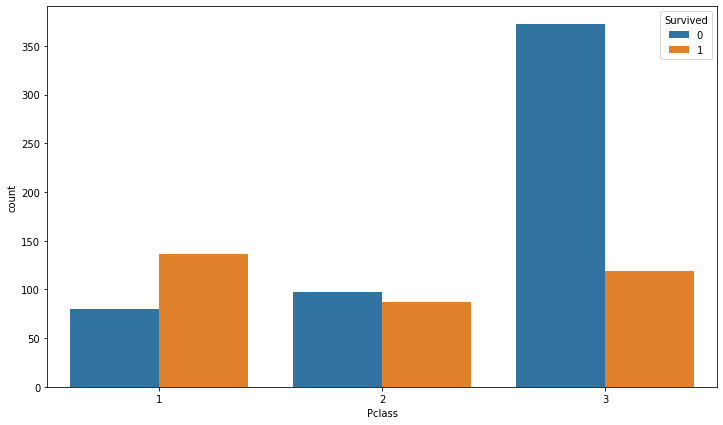

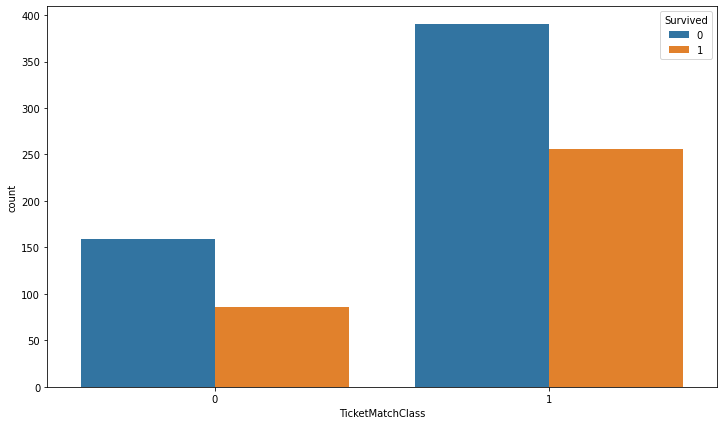

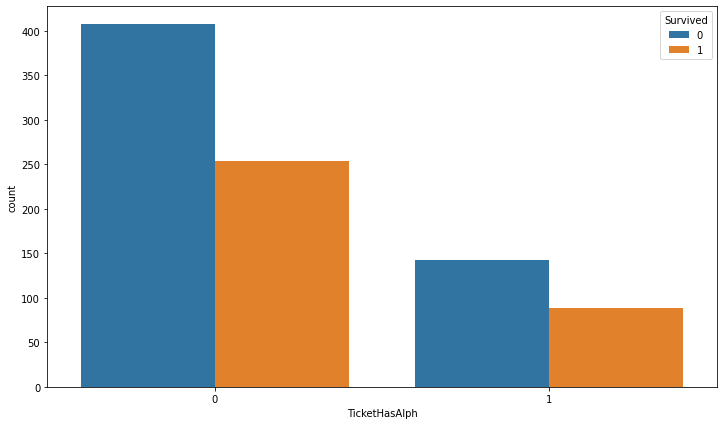

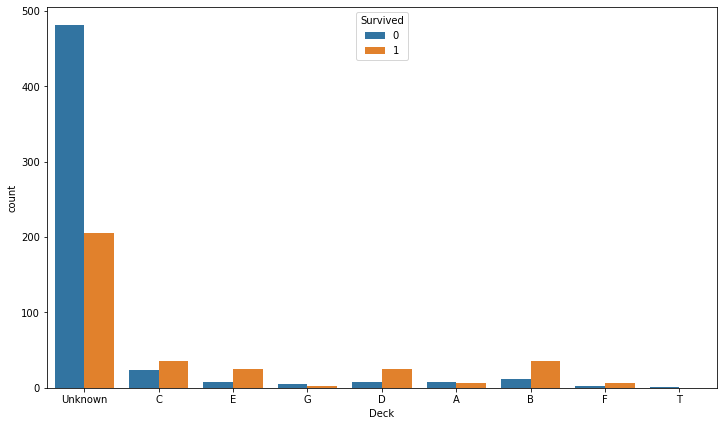

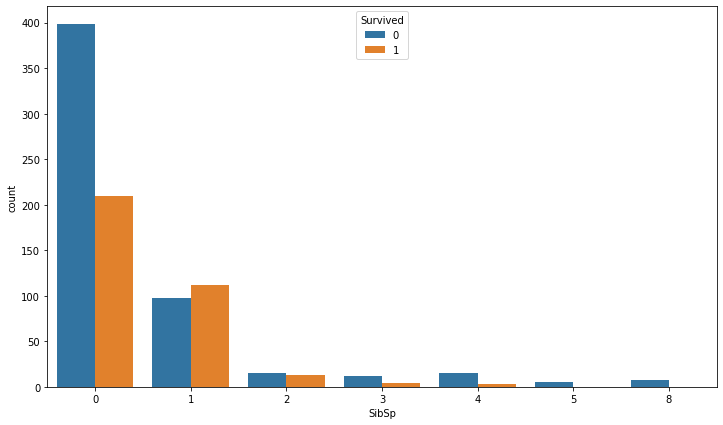

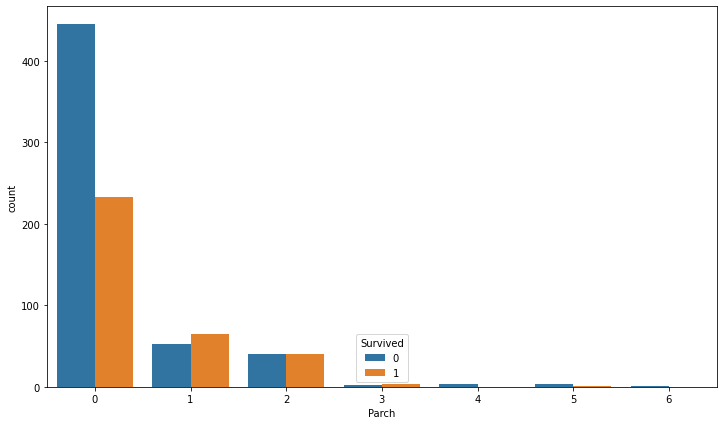

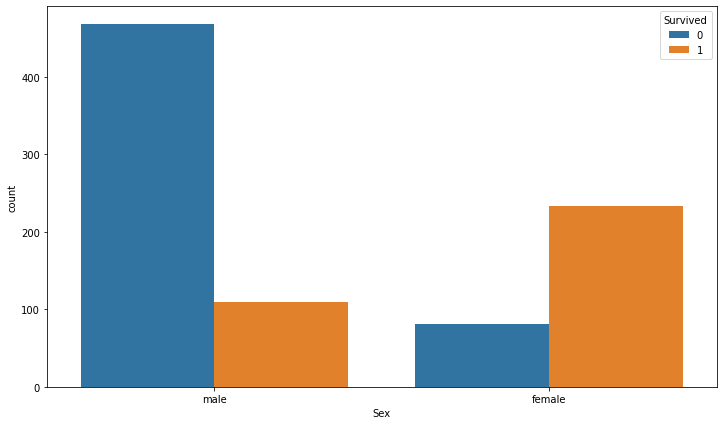

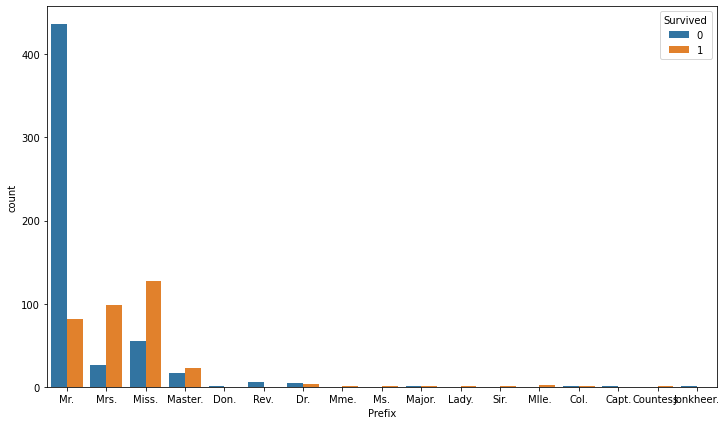

In [20]:
columns = ['Pclass', 'TicketMatchClass', 'TicketHasAlph', 'Deck', 'SibSp', 'Parch', 'Sex', 'Prefix']
for col in columns:
    plt.figure(figsize=(12, 7))
    sns.countplot(x=train[col], hue=train["Survived"])

Посмотрим, в каких колонках имеются отсутствующие значения.

In [21]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PassengerId       891 non-null    int64  
 1   Survived          891 non-null    int64  
 2   Pclass            891 non-null    int64  
 3   Name              891 non-null    object 
 4   Sex               891 non-null    object 
 5   Age               714 non-null    float64
 6   SibSp             891 non-null    int64  
 7   Parch             891 non-null    int64  
 8   Ticket            891 non-null    object 
 9   Fare              891 non-null    float64
 10  Cabin             204 non-null    object 
 11  Embarked          889 non-null    object 
 12  Prefix            891 non-null    object 
 13  Deck              891 non-null    object 
 14  TicketMatchClass  891 non-null    int64  
 15  TicketHasAlph     891 non-null    int64  
dtypes: float64(2), int64(7), object(7)
memory us

Для колонки "Age", где есть отсутствующие значения, можно применить импутацию. Колонки "Cabin" и "Name" нам больше не понадобятся, от них можно избавиться полностью. Также можно удалить колонки "Ticket" и "PassengerId". Колонка "Embarked" содержит всего два отсутствующих значения, можно просто удалить эти две строки из датафрейма.

In [22]:
train.drop(columns=["PassengerId", "Name", "Ticket", "Cabin"], inplace=True)

train.drop(index=train[train['Embarked'].isna()].index, inplace=True)

In [23]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
train_imputed = pd.DataFrame(imputer.fit_transform(train))
train_imputed.columns = train.columns

Далее используем OneHotEncoder для кодирования параметров "Embarked", "Deck" и "Prefix". Параметр "Sex" может применять только два значения, поэтому их кодируем функцией как 0 и 1.

In [24]:
train_imputed['Sex'] = train_imputed['Sex'].apply(lambda x: 0 if x == 'male' else 1)

In [25]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
object_cols = ["Embarked", "Deck", "Prefix"]
train_encoded = pd.DataFrame(encoder.fit_transform(train_imputed[object_cols]))
train_encoded.index = train_imputed.index

In [26]:
train_imputed.drop(columns=object_cols, inplace=True)
train_final = pd.concat([train_imputed, train_encoded], axis=1)

In [27]:
train_final.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,TicketMatchClass,TicketHasAlph,0,...,19,20,21,22,23,24,25,26,27,28
0,0,3,0,22.0,1,0,7.25,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,1,38.0,1,0,71.2833,1,1,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1,3,1,26.0,0,0,7.925,1,1,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1,1,1,35.0,1,0,53.1,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0,3,0,35.0,0,0,8.05,1,0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Попробуем несколько разных алгоритмов для классификации и посмотрим, какой из них даст лучший результат. ДЛя оценки качества моделей используем кросс-валидацию.

In [28]:
X_train = train_final.drop(columns='Survived')
y_train = train_final['Survived'].astype('int')

In [29]:
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
results = {}

In [30]:
gnb = GaussianNB()
scores = cross_val_score(gnb,X_train,y_train,cv=5)
print(scores, '\n', scores.mean())
results.update({'GaussianNB': scores.mean()})

[0.68539326 0.70786517 0.7752809  0.76404494 0.72316384] 
 0.7311496222941661


In [31]:
lr = LogisticRegression(max_iter = 1500)
scores = cross_val_score(lr,X_train,y_train,cv=5)
print(scores, '\n', scores.mean())
results.update({'LogisticRegression': scores.mean()})

[0.81460674 0.82022472 0.79775281 0.80898876 0.84745763] 
 0.8178061321653018


In [32]:
dt = tree.DecisionTreeClassifier(random_state = 1)
scores = cross_val_score(dt,X_train,y_train,cv=5)
print(scores, '\n', scores.mean())
results.update({'DecisionTreeClassifier': scores.mean()})

[0.75842697 0.78089888 0.83146067 0.78651685 0.79661017] 
 0.7907827080556086


In [33]:
knn = KNeighborsClassifier()
scores = cross_val_score(knn,X_train,y_train,cv=5)
print(scores, '\n', scores.mean())
results.update({'KNeighborsClassifier': scores.mean()})

[0.66292135 0.68539326 0.73595506 0.7247191  0.71751412] 
 0.7053005776677459


In [34]:
rf = RandomForestClassifier(random_state = 1)
scores = cross_val_score(rf,X_train,y_train,cv=5)
print(scores, '\n', scores.mean())
results.update({'RandomForest': scores.mean()})

[0.83707865 0.78651685 0.83707865 0.76966292 0.82485876] 
 0.8110391671427666


In [36]:
svc = SVC(probability = True)
scores = cross_val_score(svc,X_train,y_train,cv=5)
print(scores, '\n', scores.mean())
results.update({'SVC': scores.mean()})

[0.58426966 0.71348315 0.69101124 0.68539326 0.68926554] 
 0.6726845680187901


In [42]:
pd.DataFrame(data={'Model': results.keys(), 'Score': results.values()})

,Model,Score
0,GaussianNB,0.731150
1,LogisticRegression,0.817806
2,DecisionTreeClassifier,0.790783
3,KNeighborsClassifier,0.705301
4,RandomForest,0.811039
5,SVC,0.672685


По-видимому, наилучший результат достигается с применением логистической регрессии. На качество моделей могли также повлиять распределения данных, не соответствующие нормальному.